In [1]:
import os
import getpass

os.environ["OPENAI_API_KEY"] = getpass.getpass(prompt='Enter OpenAI API key: ')

Enter OpenAI API key: ··········


In [4]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(
    openai_api_key = os.environ["OPENAI_API_KEY"],
    temperature = 0,
    model_name = "gpt-4"
)

In [7]:
from langchain.agents import load_tools

tools = load_tools(
    ['llm-math'],
    llm=llm
)

In [ ]:
from langchain.agents import initialize_agent

zero_shot_agent = initialize_agent(
    agent = "zero-shot-react-description", #zero shot: no memory, uses ReAct to decide which tool to use
    tools = tools,
    llm = llm,
    verbose = True,
    max_iterations = 3
)

/Users/kevinvegda/.pyenv/versions/3.12.1/envs/NLP/lib/python3.12/site-packages/langchain_core/_api/deprecation.py:117: LangChainDeprecationWarning: The function `initialize_agent` was deprecated in LangChain 0.1.0 and will be removed in 0.2.0. Use Use new agent constructor methods like create_react_agent, create_json_agent, create_structured_chat_agent, etc. instead.
  warn_deprecated(


In [ ]:
zero_shot_agent("What is (3.5*114.2)^-2.4?")



> Entering new AgentExecutor chain...
I need to calculate the expression (3.5*114.2)^-2.4. I can use the calculator for this.
Action: Calculator
Action Input: (3.5*114.2)^-2.4
Observation: Answer: 5.69951687933452e-07
Thought:I now know the final answer.
Final Answer: 5.69951687933452e-07

> Finished chain.


{'input': 'What is (3.5*114.2)^-2.4?', 'output': '5.69951687933452e-07'}

In [ ]:
import pandas as pd
from sqlalchemy import create_engine

data = pd.read_csv("spotify-2023.csv", encoding='latin-1')
engine = create_engine('sqlite:///:memory:')

data.to_sql('Spotify_Top_Songs_2023', engine, if_exists='replace', index = False)

953

In [ ]:
from langchain.sql_database import SQLDatabase
from langchain_experimental.sql import SQLDatabaseChain

db = SQLDatabase(engine)
sql_chain = SQLDatabaseChain.from_llm(llm = llm, db = db, verbose = True)

In [ ]:
from langchain.agents import Tool

sql_tool = Tool(
    name = "Spotify Top Songs 2023 DB",
    func = sql_chain.run,
    description = "Useful for when you need to answer questions about the Spotify top songs for 2023"
)

In [ ]:
tools = load_tools(
    ["llm-math"],
    llm = llm
)

tools.append(sql_tool)

In [ ]:
from langchain.memory import ConversationBufferMemory

memory = ConversationBufferMemory(memory_key = "chat_history")

In [ ]:
conversational_agent = initialize_agent(
    agent='conversational-react-description',
    tools=tools,
    llm=llm,
    verbose=True,
    max_iterations=3,
    memory=memory,
)

In [ ]:
result = conversational_agent(
    "Who was the artist with the top song on Spotify in April 2023?"
)



> Entering new AgentExecutor chain...
Thought: Do I need to use a tool? Yes
Action: Spotify Top Songs 2023 DB
Action Input: Top song artist, April 2023

> Entering new SQLDatabaseChain chain...
Top song artist, April 2023
SQLQuery:SELECT "artist(s)_name" FROM "Spotify_Top_Songs_2023" WHERE released_month = 4 AND released_year = 2023 ORDER BY streams DESC LIMIT 1
SQLResult: [('The Weeknd, Future',)]
Answer:The top song artist in April 2023 was The Weeknd, Future.
> Finished chain.

Observation: The top song artist in April 2023 was The Weeknd, Future.
Thought:Do I need to use a tool? No
AI: The artist with the top song on Spotify in April 2023 was The Weeknd, Future.

> Finished chain.


In [ ]:
result = conversational_agent(
    "Who was the artist with the second top song in the same month?"
)



> Entering new AgentExecutor chain...
Thought: Do I need to use a tool? Yes
Action: Spotify Top Songs 2023 DB
Action Input: Who was the artist with the second top song in April 2023?

> Entering new SQLDatabaseChain chain...
Who was the artist with the second top song in April 2023?
SQLQuery:SELECT "artist(s)_name" FROM "Spotify_Top_Songs_2023" WHERE released_month = 4 ORDER BY streams DESC LIMIT 1 OFFSET 1
SQLResult: [('IU, Agust D',)]
Answer:The artist with the second top song in April 2023 was IU, Agust D.
> Finished chain.

Observation: The artist with the second top song in April 2023 was IU, Agust D.
Thought:Do I need to use a tool? No
AI: The artist with the second top song on Spotify in April 2023 was IU, Agust D.

> Finished chain.


As we can see, it answers question well from the SQL database. How does it do this? Let's look at the prompt.

In [ ]:
print(conversational_agent.agent.llm_chain.prompt.template)

Assistant is a large language model trained by OpenAI.

Assistant is designed to be able to assist with a wide range of tasks, from answering simple questions to providing in-depth explanations and discussions on a wide range of topics. As a language model, Assistant is able to generate human-like text based on the input it receives, allowing it to engage in natural-sounding conversations and provide responses that are coherent and relevant to the topic at hand.

Assistant is constantly learning and improving, and its capabilities are constantly evolving. It is able to process and understand large amounts of text, and can use this knowledge to provide accurate and informative responses to a wide range of questions. Additionally, Assistant is able to generate its own text based on the input it receives, allowing it to engage in discussions and provide explanations and descriptions on a wide range of topics.

Overall, Assistant is a powerful tool that can help with a wide range of tasks 

In [ ]:
from langchain import Wikipedia
from langchain.agents.react.base import DocstoreExplorer

docstore = DocstoreExplorer(Wikipedia())
tools = [
    Tool(
        name = "Search",
        func = docstore.search,
        description = "search wikipedia"
    ),
    Tool(
        name = "Lookup",
        func = docstore.lookup,
        description = "lookup a term in wikipedia"
    )
]

In [ ]:
docstore_agent = initialize_agent(
    tools,
    llm,
    agent = "react-docstore",
    verbose = True,
    max_iterations = 3
)

In [ ]:
docstore_agent("Where is Karl Marx buried?")



> Entering new AgentExecutor chain...
Thought: I need to search Karl Marx and find where he is buried.
Action: Search[Karl Marx]
Observation: Could not find [Karl Marx]. Similar: ['Karl Marx', 'Tomb of Karl Marx', 'Karl-Marx-Allee', 'Karl Marx University', 'The Young Karl Marx', 'Karl-Marx-Hof', 'FC Erzgebirge Aue', 'Chemnitz', 'Marxism', 'Karl Marx House']
Thought:To find where Karl Marx is buried, I can search Tomb of Karl Marx.
Action: Search[Tomb of Karl Marx]
Observation: The Tomb of Karl Marx stands in the Eastern cemetery of Highgate Cemetery, North London, England. It commemorates the burial sites of Marx, of his wife, Jenny von Westphalen, and other members of his family. Originally buried in a different part of the Eastern cemetery, the bodies were disinterred and reburied at their present location in 1954. The tomb was designed by Laurence Bradshaw and was unveiled in 1956, in a ceremony led by Harry Pollitt, the General Secretary of the Communist Party of Great Britain, w

{'input': 'Where is Karl Marx buried?',
 'output': 'Eastern cemetery of Highgate Cemetery, North London, England'}

In [ ]:
import getpass

os.environ["SERP_API_KEY"] = getpass.getpass()

In [ ]:
from langchain import SerpAPIWrapper

search = SerpAPIWrapper(serpapi_api_key = os.environ["SERP_API_KEY"]) #allows searching from google

In [ ]:
tools = [
    Tool(
        name = "Intermediate Answer",
        func = search.run,
        description = 'google search'
    )
]

self_ask_with_search = initialize_agent(
    tools,
    llm,
    agent = "self-ask-with-search",
    verbose = True
)

In [ ]:
self_ask_with_search(
    "What came first: Theory of mind, theory of the atom, or theory of the cell?"
)



> Entering new AgentExecutor chain...
Yes.
Follow up: When was the theory of mind first proposed?
Intermediate answer: 1978
Follow up: When was the theory of the atom first proposed?
Intermediate answer: 5th century bce
Follow up: When was the theory of the cell first proposed?
Intermediate answer: The classical cell theory was proposed by Theodor Schwann in 1839. There are three parts to this theory. The first part states that all organisms are made of cells.
So the final answer is: Theory of the atom

> Finished chain.


{'input': 'What came first: Theory of mind, theory of the atom, or theory of the cell?',
 'output': 'Theory of the atom'}

As we can see, our agent searches from Google and answers our question well.

We can combine the multiple tools we've given our agents above to get an agent that can accomplish tasks such as:
- Look at an SQL table
- Look up information on Wikipedia
- Make Google Searches

Let's now add even more tools to our agent(s)

In [9]:
import torch
from transformers import BlipProcessor, BlipForConditionalGeneration

hf_model = "Salesforce/blip-image-captioning-large"
device = "cuda" if torch.cuda.is_available() else "cpu"

processor = BlipProcessor.from_pretrained(hf_model)
model = BlipForConditionalGeneration.from_pretrained(hf_model).to(device)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/445 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/527 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.60k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.88G [00:00<?, ?B/s]

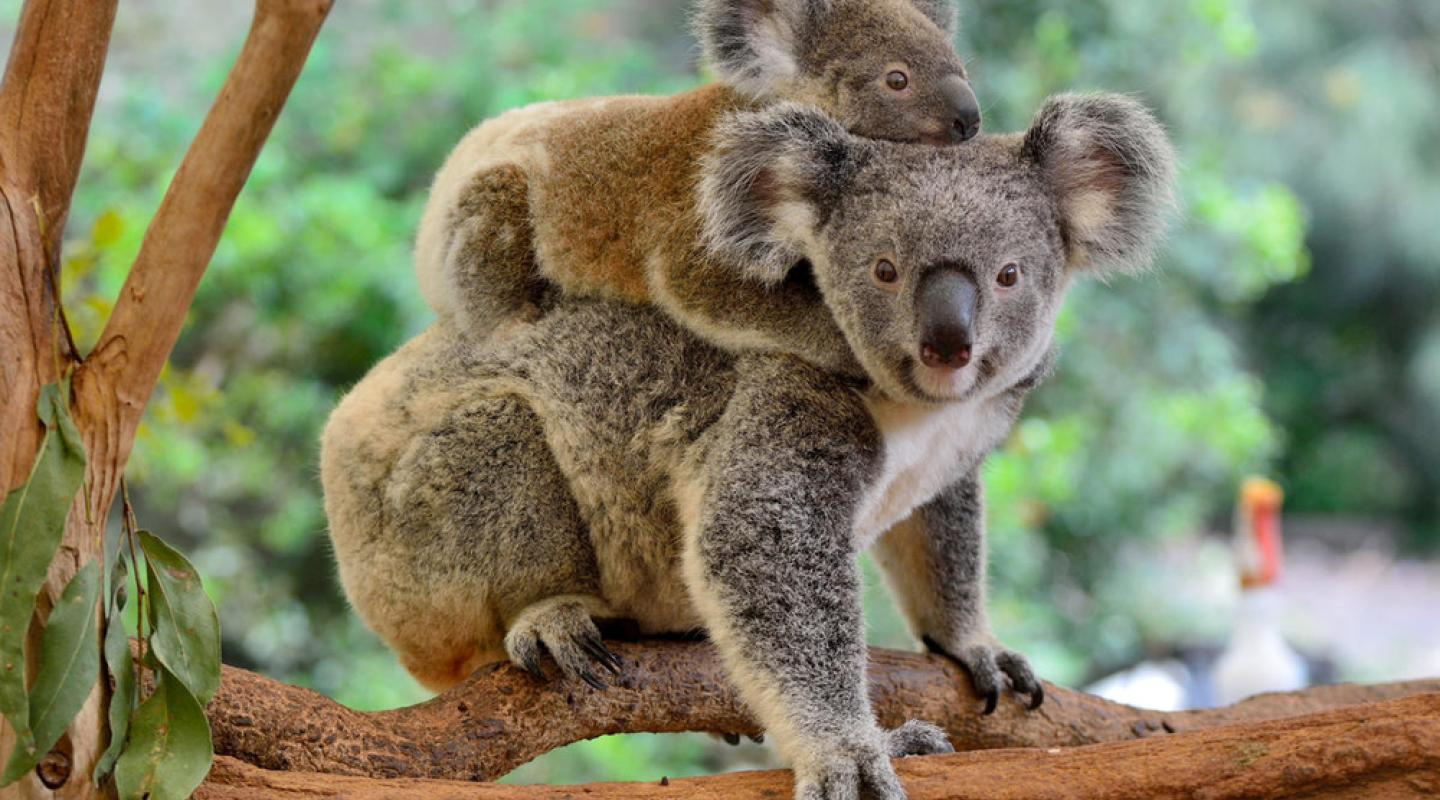

In [10]:
import requests
from PIL import Image

img_url = 'https://www.wwf.org.uk/sites/default/files/styles/gallery_image/public/2022-05/_WW2138268.jpg?h=82f92a78&itok=6Tzbnk_H'
image = Image.open(requests.get(img_url, stream=True).raw).convert('RGB')
image

In [11]:
inputs = processor(image, return_tensors = "pt").to(device)

out = model.generate(**inputs, max_new_tokens = 20)
print(processor.decode(out[0], skip_special_tokens = True))

there are two koalas that are sitting on a tree branch


In [12]:
from langchain.tools import BaseTool

desc = (
    "use this tool when given the URL of an image that you'd like to be "
    "described. It will return a simple caption describing the image."

)

class ImageCaptionTool(BaseTool):
  name = "Image captioner"
  description = desc

  def _run(self, url: str):
    image = Image.open(requests.get(url, stream=True).raw).convert('RGB')
    inputs = processor(image, return_tensors = "pt").to(device)
    out = model.generate(**inputs, max_new_tokens = 20)
    caption = processor.decode(out[0], skip_special_tokens = True)
    return caption

  def _arun(self, query: str):
    raise NotImplementedError("This tool does not support async")

tools = [ImageCaptionTool()]

In [21]:
from langchain.agents import AgentExecutor, create_structured_chat_agent
from langchain import hub

prompt = hub.pull("hwchase17/structured-chat-agent")

agent = create_structured_chat_agent(llm, tools, prompt)

agent_executor = AgentExecutor(
    agent=agent, tools=tools, verbose=True, handle_parsing_errors=True, max_iterations = 3
)

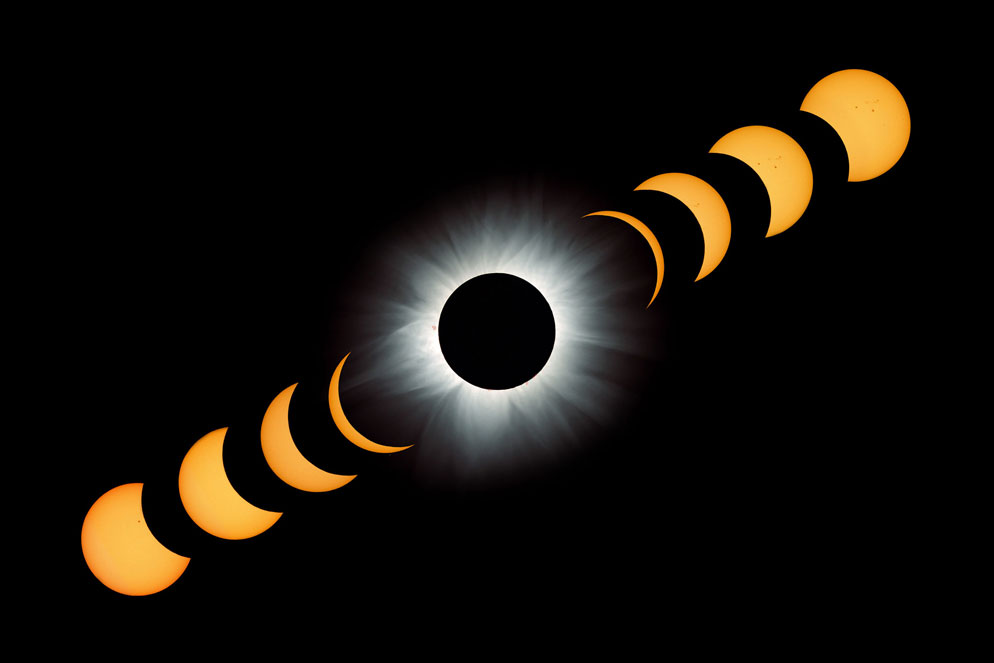

In [24]:
img_url = "https://cdn-7.nikon-cdn.com/Images/Learn-Explore/Photography-Techniques/2012/Solar-Eclipses-Fred-Espenak/Media/SolarEclipse-Espenak-T01-03_01.jpg"
image = Image.open(requests.get(img_url, stream=True).raw).convert('RGB')
image

In [23]:
img_url = "https://cdn-7.nikon-cdn.com/Images/Learn-Explore/Photography-Techniques/2012/Solar-Eclipses-Fred-Espenak/Media/SolarEclipse-Espenak-T01-03_01.jpg"
agent_executor.invoke({"input": f"what does this image show?\n{img_url}"})



> Entering new AgentExecutor chain...
Action:
```
{
  "action": "Image captioner",
  "action_input": {
    "url": "https://cdn-7.nikon-cdn.com/Images/Learn-Explore/Photography-Techniques/2012/Solar-Eclipses-Fred-Espenak/Media/SolarEclipse-Espenak-T01-03_01.jpg"
  }
}
```a close up of a solar eclipse with a black backgroundThe image shows a close up of a solar eclipse against a black background.

Action:
```
{
  "action": "Final Answer",
  "action_input": "The image shows a close up of a solar eclipse against a black background."
}
```

> Finished chain.


{'input': 'what does this image show?\nhttps://cdn-7.nikon-cdn.com/Images/Learn-Explore/Photography-Techniques/2012/Solar-Eclipses-Fred-Espenak/Media/SolarEclipse-Espenak-T01-03_01.jpg',
 'output': 'The image shows a close up of a solar eclipse against a black background.'}